In [1]:
from datacube.utils.dask import start_local_dask
from dep_tools.namers import LocalPath
from dep_tools.writers import LocalDsCogWriter

from src.run_task import get_tiles, MLProcessor, add_indices

from dep_tools.searchers import PystacSearcher
from dep_tools.loaders import OdcLoader

import xarray as xr

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Optionally set up a local dask cluster
client = start_local_dask()
client.dashboard_link

'http://127.0.0.1:8787/status'

In [4]:
# Issues

# Study site configuration
tile_id = "63,21"
year = "2023"

# And get the study site
tiles = get_tiles()
area = tiles.loc[[(tile_id)]]
area.explore()

In [5]:
# Find some items
searcher = PystacSearcher(
    catalog="https://stac.staging.digitalearthpacific.org",
    collections=["dep_s1_mosaic", "dep_s2_geomad"],
    datetime=year
)

items = searcher.search(area)

items_by_collection = {}
for item in items:
    items_by_collection.setdefault(item.collection_id, []).append(item)

dem_searcher = PystacSearcher(
    catalog="https://planetarycomputer.microsoft.com/api/stac/v1",
    collections=["cop-dem-glo-30"]
)
items_by_collection["cop-dem-glo-30"] = dem_searcher.search(area)

print({k: len(v) for k, v in items_by_collection.items()})

{'dep_s2_geomad': 6, 'dep_s1_mosaic': 6, 'cop-dem-glo-30': 4}


In [20]:
data = None

# Set up a data loader
loader = OdcLoader(
    resolution=10,
    crs=3832,
    groupby="solar_day",
    chunks=dict(time=1, x=4096, y=4096),
    fail_on_error=False
)

# Run the load process, which is lazy-loaded

all_data = [loader.load(items, area).squeeze("time") for items in items_by_collection.values()]

loaded = xr.merge(all_data, compat='override')
loaded = loaded.rename({"data": "elevation"})
loaded = loaded.drop_vars(["median_vv", "median_vh", "std_vv", "std_vh"])
loaded

<xarray.Dataset>
Dimensions:      (y: 9600, x: 9600)
Coordinates:
  * y            (y) float64 -1.888e+06 -1.888e+06 ... -1.984e+06 -1.984e+06
  * x            (x) float64 3.048e+06 3.048e+06 ... 3.144e+06 3.144e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2023-01-01
Data variables: (12/17)
    B02          (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    B03          (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    B04          (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    B05          (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    B06          (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    B07          (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    ...           ...
    smad         (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    bcmad        (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    count        (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    mean_vh      (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    mean_vv      (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    elevation    (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>

In [21]:
input_data = add_indices(loaded)
input_data

<xarray.Dataset>
Dimensions:      (y: 9600, x: 9600)
Coordinates:
  * y            (y) float64 -1.888e+06 -1.888e+06 ... -1.984e+06 -1.984e+06
  * x            (x) float64 3.048e+06 3.048e+06 ... 3.144e+06 3.144e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2023-01-01
Data variables: (12/24)
    B02          (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    B03          (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    B04          (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    B05          (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    B06          (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    B07          (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    ...           ...
    mndwi        (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    evi          (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    savi         (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    bsi          (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    ndmi         (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>
    ndbi         (y, x) float32 dask.array<chunksize=(4096, 4096), meta=np.ndarray>

In [23]:
# Set up a data processor
processor = MLProcessor(model_path="models/test_model.dump", load_data=True)

# Plan the processing.
output_data = processor.process(input_data)
output_data

predicting...
   probabilities...


<xarray.Dataset>
Dimensions:      (x: 9600, y: 9600)
Coordinates:
  * x            (x) float64 3.048e+06 3.048e+06 ... 3.144e+06 3.144e+06
  * y            (y) float64 -1.888e+06 -1.888e+06 ... -1.984e+06 -1.984e+06
    spatial_ref  int32 3832
Data variables:
    class        (y, x) int8 7 7 7 7 7 7 7 7 7 7 7 7 ... 1 1 1 3 3 6 6 6 6 6 6 6
    proba        (y, x) float32 60.12 60.12 60.12 60.04 ... 19.94 18.49 18.49
Attributes:
    grid_mapping:     spatial_ref
    stac_properties:  {'start_datetime': '2023-01-01T00:00:00.000Z', 'datetim...

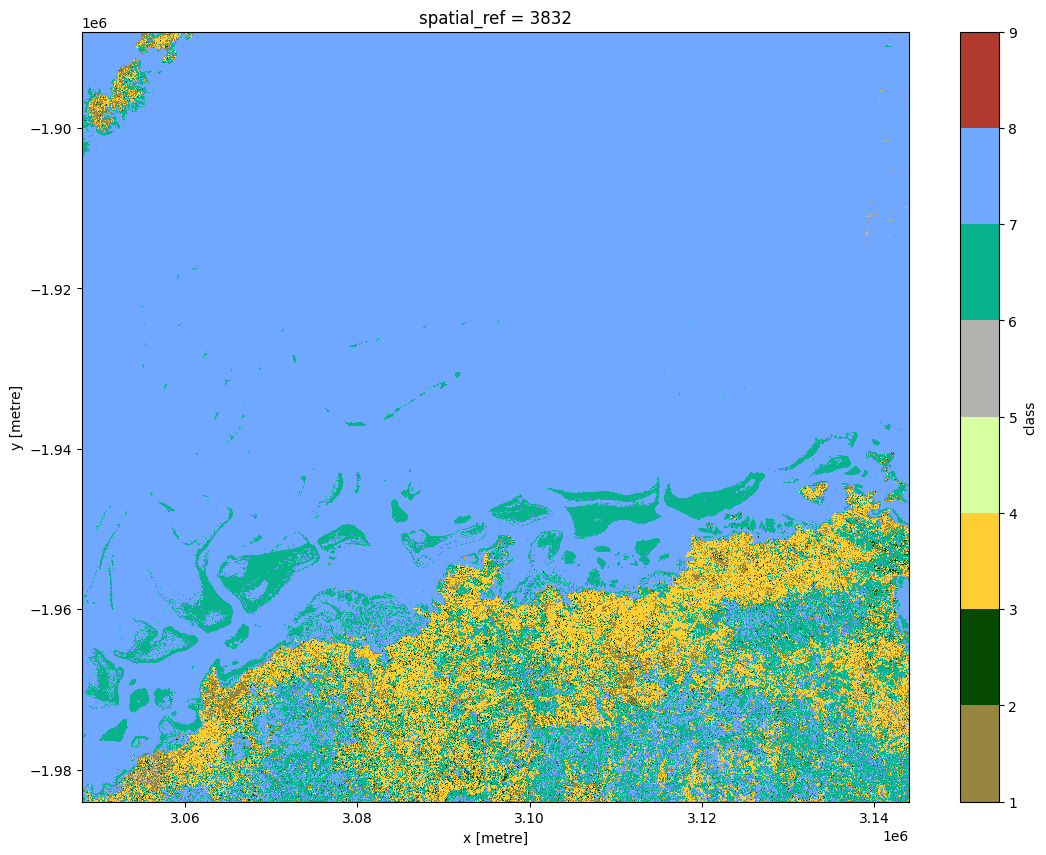

In [24]:
from matplotlib import colors

classes = [
    [1, "bare_land", "#968640"],
    [2, "forest", "#064a00"],
    [3, "crops", "#ffce33"],
    [4, "grassland", "#d7ffa0"],
    [5, "settlements", "#b3b2ae"],
    [6, "mangroves", "#07b28d"],
    [7, "water", "#71a8ff"],
    [8, "quarry", "#b03a2e"]
]

values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [9]
norm = colors.BoundaryNorm(bounds, c_map.N)

output_data["class"].plot.imshow(cmap=c_map, norm=norm, size=10)

In [26]:
for var in output_data.data_vars:
    output_data[var].odc.write_cog(f"test_{var}.tif", overwrite=True)


In [ ]:
# Testing the Azure writer

# from dep_tools.writers import AzureDsWriter
# from dep_tools.namers import DepItemPath

# itempath = DepItemPath("geomad", "test", "0.0", datetime)

# writer = AzureDsWriter(
#     itempath=itempath,
#     overwrite=True,
#     convert_to_int16=False,
#     extra_attrs=dict(dep_version="0.0"),
# )

# writer.write(output_data, "test")


In [ ]:
# Testing the AWS writer

from dep_tools.writers import AwsDsCogWriter
from dep_tools.namers import DepItemPath

itempath = DepItemPath("geomad", "test", "0.0", datetime)

writer = AwsDsCogWriter(
    itempath=itempath,
    overwrite=False,
    convert_to_int16=False,
    extra_attrs=dict(dep_version="0.0"),
    bucket="files.auspatious.com"
)

writer.write(output_data, "test")

In [ ]:
from odc.stac import load
from pystac import Item

item = Item.from_file("https://deppcpublicstorage.blob.core.windows.net/output/dep_geomad_test/0-0/test/2023-01/dep_geomad_test_test_2023-01.stac-item.json")

data = load([item], chunks={})
data

In [ ]:
# This is the target path
dep_path = LocalPath(
    local_folder="data",
    sensor="s1",
    dataset_id="mosaic",
    version="0.0.0",
    time=datetime,
    zero_pad_numbers=True
)

# Set up a writer and write out the files
writer = LocalDsWriter(
    itempath=dep_path,
    output_nodata=0,
    use_odc_writer=True,
    overwrite=True,
    convert_to_int16=False
)
print(f"Writing to: {dep_path._folder(item_id)}")
out_files = writer.write(output_data, item_id)

In [ ]:
# Make sure written files are readable
stac_path = writer.itempath.path(item_id, ext=".stac-item.json")

item = Item.from_file(stac_path)
item.validate()

In [ ]:
from pystac import Item
from odc.stac import load
from odc.stac import configure_s3_access

configure_s3_access(cloud_defaults=True, aws_unsigned=True)
item = Item.from_file("https://dep-public-test.s3.us-west-2.amazonaws.com/dep_s1_mosaic/0-0-3b/066/020/2023/dep_s1_mosaic_066_020_2023.stac-item.json")

data = load([item], chunks={})

In [ ]:
data.isel(time=0).mean_vv.plot.imshow(size=10, robust=True)